# Purpose: To understanding the Boston House Price dataset

## Techniques use: Visualization + Linear Regression + Decision Tree + Random Forest + Comparison between these methods

### Outline:

    Step 1: Getting and setting up the data.
    Step 2: Load the data.
    Step 3: Visualize the data (cleaning not needed, only some pre-processing).
    Step 4: Do a LS- Simple Linear Regression (Using Numpy), calculate the error.
    Step 5: Using scikit learn to implement a multivariate regression (use .fit() to train and .predict() to predict new labels.
    Step 6: Using Training and Validation, Predicting Prices
    Step 7: Residual Plots (To check for normality of residuals)
    
    Step 8: Use Decision Tree (lone tree) and Random Forest to predict and compare that to LR

# Step 1: Importing

** Note that this is a sklearn's built-in dataset.** To read it, you can either import it directly from scikit-learn, or read from the file containing the data (found at https://archive.ics.uci.edu/ml/machine-learning-databases/housing/)

** This dataset has no missing values. Otherwise, cleaning/preprocessing is needed**

    * Checking for wierd values/missing values/outliers in our data
        * Wierd/ridiculous data should be checked.
        * Outliers: values outside the range 1.5 Inter-Quantiles, i.e. 1.5*(Q3-Q1)
    * Investigate why these happened? Consider removing these values, or replacing them by medians

### Import for reading and working with data

In [1]:
import numpy as np 
import pandas as pd
from pandas import Series,DataFrame

### Import for modeling and plotting the result

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


# Imports that only needed for Multiple Linear Regression
import sklearn
from sklearn.linear_model import LinearRegression


#Imports that only needed for comparison between LR and DT as well as RF later.
from sklearn.preprocessing import LabelEncoder, StandardScaler
# LabelEncoder is needed to convert categorical variables to numerical variables
# StandardScaler is to normalizing numerical variables.

#Importing the other 2 models: Decision Tree and Random Forest
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#to calculate cross validation score, a benchmark to eval how the model will perform
#on new test data. The higher the better. By default, it uses K-fold CV
#we can also choose StratifiedKFold , which is the same as K-Fold 
#but preserves the class distribution within each fold.
from sklearn.model_selection import cross_val_score

# Step 2: Read data

### Method1: it's built-in in sklearn, so we can import directly:

In [3]:
from sklearn.datasets import load_boston
boston = load_boston()
type(boston) #sklearn.datasets.base.Bunch

# Similar to sklearn, seaborn also has its built-in dataset, for example:
# tips = sns.load_dataset("tips") # The "tips" dataset in seaborn.

sklearn.datasets.base.Bunch

Note that now boston is a sklearn object (it is not a dataframe yet). With this sklearn object, we can call:
1. boston.target, which is the prices of the house. This is our dependent variable.
2. boston.data, which is all the 13 attributes for this data (representing the 13 independent variables).

**Note that here I am assuming the 13 feature variables are independent and build models using all 13. For real-world datasets, it would be a good idea to check for possible correlations between each pair of features variables, as well as between the depedent variable and the indepdendent variables (by calculating the matrix of correlation coefficient between those). The possible advantages of such "pre-processing" is to reduce the number of variables in our model (correlated variables, or useless variable) and thus simplify the model.**

Let's see what the data set contains

In [4]:
print(boston.DESCR)
#if the dataset is loaded in to the data frame format, use df.info()

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

**So, INTPUT are those 13 attributes/features. OUTPUT is the 'MEDV' (median value of owner-occupied homes in $1000's. We also call it the TARGET/LABEL **

<span style="color:red">**Objective: Predict the output (price of the house) based on the input attributes.**</span>

### Method2: read it from the data file available at:
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

In [5]:
df = pd.read_csv('./housing.data', header=None, sep=r"\s*", engine='python')
#set the columns name for easy referring.
df.columns = [
        'crim', # numerical
        'zn', # numerical
        'nonretail', # numerical
        'river', # binary
        'nox', # numerical
        'rooms', # numerical
        'age', # numerical
        'dis', # numerical
        'rad', # numerical
        'tax', # numerical
        'ptratio', # numerical
        'b', # numerical
        'lstat', # numerical
        'medv', # numerical -- this is the target
]
df.head()

C:\Users\Tho7\Anaconda3\lib\site-packages\pandas\io\parsers.py:1728: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\Tho7\Anaconda3\lib\site-packages\pandas\io\parsers.py:1730: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


,crim,zn,nonretail,river,nox,rooms,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# Step 3: Visualizing current data

Doing a quick visualization for the data is always recommended. Let's go ahead an make a histogram of the prices.

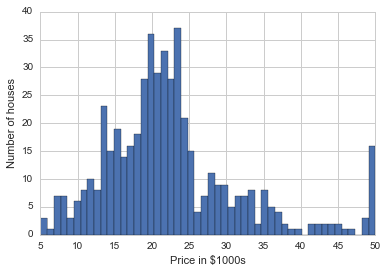

In [6]:
# Histogram of prices (this is the target of our dataset)
plt.hist(boston.target,bins=50)

#label
plt.xlabel('Price in $1000s')
plt.ylabel('Number of houses')

In [7]:
boston.target # type(boston.target) --> a numpy array. 
#If we read the data in as a dataframe, we'll need to
# convert it: target = np.array(target)

array([ 24. ,  21.6,  34.7,  33.4,  36.2,  28.7,  22.9,  27.1,  16.5,
        18.9,  15. ,  18.9,  21.7,  20.4,  18.2,  19.9,  23.1,  17.5,
        20.2,  18.2,  13.6,  19.6,  15.2,  14.5,  15.6,  13.9,  16.6,
        14.8,  18.4,  21. ,  12.7,  14.5,  13.2,  13.1,  13.5,  18.9,
        20. ,  21. ,  24.7,  30.8,  34.9,  26.6,  25.3,  24.7,  21.2,
        19.3,  20. ,  16.6,  14.4,  19.4,  19.7,  20.5,  25. ,  23.4,
        18.9,  35.4,  24.7,  31.6,  23.3,  19.6,  18.7,  16. ,  22.2,
        25. ,  33. ,  23.5,  19.4,  22. ,  17.4,  20.9,  24.2,  21.7,
        22.8,  23.4,  24.1,  21.4,  20. ,  20.8,  21.2,  20.3,  28. ,
        23.9,  24.8,  22.9,  23.9,  26.6,  22.5,  22.2,  23.6,  28.7,
        22.6,  22. ,  22.9,  25. ,  20.6,  28.4,  21.4,  38.7,  43.8,
        33.2,  27.5,  26.5,  18.6,  19.3,  20.1,  19.5,  19.5,  20.4,
        19.8,  19.4,  21.7,  22.8,  18.8,  18.7,  18.5,  18.3,  21.2,
        19.2,  20.4,  19.3,  22. ,  20.3,  20.5,  17.3,  18.8,  21.4,
        15.7,  16.2,

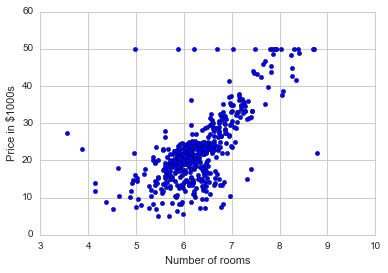

In [8]:
# Plot the column at the 5 index (Labeled RM) (Check back the dataset description)
plt.scatter(boston.data[:,5],boston.target)# we are plotting using all data points,

plt.ylabel('Price in $1000s')
plt.xlabel('Number of rooms')

Doing this scatter plot is important to discover the pattern in data. As this plot show, using LR to predict Price on the basis of the number of rooms might be a reasonable choice. Moreover, later we will see how we can improve the prediction by adding more features in to the prediction. **In particular, using a MLR model with all the features included, we get back a set of estimated coefficients (slopes), each corresponds to a single feature. We will then need to verify that the coefficient corresponding to the number of the room is positive and is the highest among all other coefficients.**

Another way to verify that your LR model is a good model is to check other scores, such as R^2 value (higher better), or SSE (lower, better). (doing as a post-model activity). BUT one good way to do even before modelling is VISUALIZATION. This means you can check by simply plotting the <span style="color:red">Residuals Plot</span> (will do this in a moment). NOTE that I stress the keyword: visualization! It is the best way to see which model to choose as well as to verify the chosen model! 
(However, remember though that some characteristics might be missing if just looking at the visualization alone).

Another post-modelling activity is doing **Residuals plot**, a good way to visualize the errors in the data.  **If we have done a good job then the residuals (observed dependent variable - predicted dependent variable) should be randomly scattered around line zero**. 

#### If there is some strucutre or pattern in the residuals plot, that means our model is not capturing something. For example, there could be an interaction between 2 variables that we were not considering, or may be we were measuring time dependent data. If this is the case go back to our model and check our data set closely.

To check this linear pattern further, we can use seaborn to do an lmplot which produce a scatter plot with a linear fit line **automatically!**. 

**Seaborn do that directly on a DataFram object, thus first we need to convert the boston object to a boston dataframe.**

In [9]:
# reset data as pandas DataFrame
boston_df = DataFrame(boston.data)
#easy name to remember: "boston" is a sklearn object, while "boston_df" is a DF.

# label columns (otherwise, the columns names will be 0,1,2... by default)
boston_df.columns = boston.feature_names
#this feature_names method is also built-in. 
#Otherwise, check the above for how to manually label the columns

#show
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Now let's add the target of the boston data set, the price. We'll create a new column in our DataFrame.
** Note that boston.target is a numpy array. But here we actually set the new column of a dataframe to be equal to boston.target**

In [10]:
# Set price column for target
boston_df['Price'] = boston.target

Now let's check the resulting DataFrame to see the Price column!

In [11]:
# Show result
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


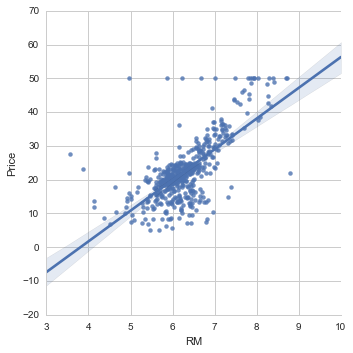

In [12]:
# Using seabron to create a linear fit
sns.lmplot('RM','Price',data = boston_df)

Check out the other built-in dataset of seaborn: The **tip** dataset

http://seaborn.pydata.org/generated/seaborn.lmplot.html

# Step 4: Do a LS- Simple Linear Regression (Using Numpy), calculate the error.

**Numpy** has a **built in** **Least Square Method** in its linear algebra library. We'll use this first for our **Univariate regression**, even though we can also try using seaborn: sns.lmplot('RM','Price', data=boston_df) as above.

Later, we move on to **scikit learn** for our **Multi variate regression** (as it's complicated to use numpy for such).

We will start by setting up the X and Y arrays for numpy to take in. An important note **for the X array**: **Numpy expects a two-dimensional array**, **the first dimension is the different example values**, and **the second dimension is the attribute number**. In this case we have our value as the mean number of rooms per house, and this is a single attribute so the second dimension of the array is just 1. So **we'll need to create a (506,1) shape array**. There are a few ways to do this, but an **easy way** to do this is by using **numpy's built-in** **vertical stack tool**, vstack.

In [13]:
# Use vstack to make X two-dimensional
X = np.vstack(boston_df.RM)
# check the shape of X right now: X.shape --> give (506L,1L). This difference
# is what numpy needs: how many values you have: 506, and how many attributes
# there was: 1 (i.e., the ave number of rooms).
# now, X is already a numpy array
# Note that the difference between simply doing X=np.array(boston_df.RM)
# and X=np.vstack(boston_df.RM) (what we need) is:
# np.array(boston_df.RM) returns a numpy array of shape (506,)
# np.vstack(boston_df.RM) returns a numpy array of shape (506, 1),
# i.e. an array of arrays, i.e. a matrix with only 1 column

# Set up Y as the target price of the houses. This is straightforward.
Y = boston_df.Price

#### Now, need to make X an array of arrays by adding the intercept. The reason is:
We know that a line has the equation:
$$y=mx+b$$
which we can rewrite using matrices:
$$y=Ap$$
where:
$$A = \begin{bmatrix}x & 1\end{bmatrix}$$
and
$$p= \begin{bmatrix}m \\b\end{bmatrix}$$

This is the same as the first equation if you carry out the linear algebra. 
So we'll **start by creating the A matrix using numpy**. We'll do this by creating **a matrix in the form [X 1]**, so we'll **call every value in our original X using a list comprehension** and then **set up an array in the form [X 1]**

In [14]:
# Create the X array in the form [X 1]
X = np.array( [ [value,1] for value in X ] )
X
#X.shape #(506, 2)
#type(X) #numpy.ndarray

#note that the inverse function of np.array() is pd.Series()
#which converts a numpy array back to a pandas series (i.e. a col of a dataframe)

array([[array([ 6.575]), 1],
       [array([ 6.421]), 1],
       [array([ 7.185]), 1],
       ..., 
       [array([ 6.976]), 1],
       [array([ 6.794]), 1],
       [array([ 6.03]), 1]], dtype=object)

Great! Now we can get the best fit values! Using ** least squares**

In [15]:
# Now get out m and b values for our best fit line: y=mx + b
m, b = np.linalg.lstsq(X, Y)[0]
# .linalg:To tell numpy to use LR
# .lstsq: To tell numpy the criteria we are using is least square

In [16]:
print(m)
print(b)

9.10210898118
-34.6706207764


Finally let's plot it all together! Note that we use the original format of the boston information. We only did our matrix transformations to utilize the numpy least square method.

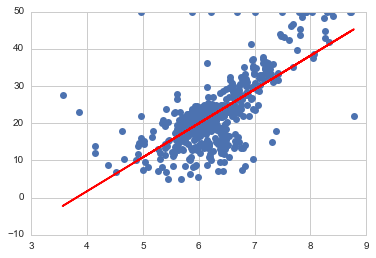

In [17]:
# First the ORIGINAL SCATTER points, Price vs Avg Number of Rooms
plt.plot(boston_df.RM,boston_df.Price,'o') #change to 's' if want square bullets

# Next the BEST FIT LINE
x= boston_df.RM # NOTE THAT WE USE lower case x here, not X
# since X's format was modified as (506L,1L)
# we just want the origial col of ave number of room here as x
plt.plot(x, m*x + b,'r',label='Best Fit Line')
# actually, you can also do plt.plot(X, m*X + b,'r',label='Best Fit Line'), 
#but the the figure appears on different scale.

#### Again, note that we can do all the above using seaborn built-in method: 
sns.lmplot('RM','Price', data=boston_df), which actually also provide more info on the plot

## Evaluate our model by calculating the Mean (Training) error in our fitted line (sum of all the squared error between the fitted line and data points, divided by the number of data points, and taken by sqrt)

(since we are using all 506 data points. We will do the same for MLR with all 506 data points, but then will also check out Cross-Validation by dividing 75%-25% training vs testing)

Checking out the documentation [here](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html)

In [19]:
# Get the resulting array
result = np.linalg.lstsq(X,Y)
#while above, m, b = np.linalg.lstsq(X, Y)[0]
result
# interpreting this result (read the documentation given in the link above)
# array([  9.10210898, -34.67062078]): our coeff estimates, so beta1=9.10 is the slope
# beta0 = -34.67 is the intercept, which is not meaningful in this case: when the house has 0 room,
# its price cannot be negative!
# array([ 22061.87919621]) is the SSE (i.e. sum of squares errors/residual.)
# We'll need to divide this SSE by number of observations and then take square root.
# to have RMSE
# 2 is just the rank of the matrix A=[x 1]
# array([ 143.99484122,    2.46656609]) are the singular values of the matrix A = [x 1]

(array([  9.10210898, -34.67062078]),
 array([ 22061.87919621]),
 2,
 array([ 143.99484122,    2.46656609]))

#### The model returns SSE, we'll need to calculate RMSE by dividing SSE by the number of observations and taking the square root.

In [20]:
# here, error_total is simply the sum of squares error SSE (sum of square of the residuals)
error_total = result[1]

# Get the root mean square error
rmse = np.sqrt(error_total/len(X) )

print("The root mean squared error was %.2f " %rmse)

The root mean squared error was 6.60 


Since <span style="color:red">**the root mean square error (RMSE) corresponds approximately to the standard deviation**</span> we can now say that **the price of a house won't vary more than 2 times the RMSE in 95% of the time**. (Check out [link](http://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)).

## Thus we can reasonably expect a house price to be within 2 x RMSE x unit of 1,000 = 13,200 (dollars) of our line fit.

# Step 5: Using scikit learn to implement a MLR

**Note that we need to import the [linear regression library](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from the sklearn module.** (which we already did at the beginning of the notebook)
    * import sklearn
    * from sklearn.linear_model import LinearRegression

The **sklearn.linear_model.LinearRegression** class is **an estimator**. Estimators predict a value based on the observed data. In scikit-learn, <span style="color:red">**all estimators** implement the **fit()** and **predict()** methods.</span> The **.fit()** method is used to learn the parameters of a model, and the **.predict()** method is used to predict the value of a response variable for an explanatory variable using the learned parameters. It is easy to experiment with different models using scikit-learn because all estimators implement the fit and predict methods.

Next, we **create** a **LinearRegression object**, afterwards, **type lm. then press tab to see the list of methods availble on this object**.

The functions we will be using are:

<span style="color:red">**lreg.fit()</span> which fits a linear model (i.e. by returning the model's estimated coefficients)**

<span style="color:red">**lreg.predict()</span> which is used to predict Y using the linear model with estimated coefficients**

<span style="color:red">**lreg.score()</span> which returns the coefficient of determination (R^2). A measure of how well observed outcomes are replicated by the model, learn more about it [here](http://en.wikipedia.org/wiki/Coefficient_of_determination)**

**A perfect R^2 value is 1. The higher it is from 0, the better fit our model is.**

SST = SSE + SSR (Total sum of squares = sum of squares errors + sum of squares regression), where:
    * SST: total variation in our data
    * SSR: total variation in our data that can be explained by the model
    * SSE: unexplained varations in the data

<span style="color:red">**R^2 = SSR/SST: the percent of the variation in Y that is explained by X using this LR model.**</span>

In [21]:
# Create a LinearRegression Object
lreg = LinearRegression()
#type(lreg) #sklearn.linear_model.base.LinearRegression

We'll start the multi variable regression analysis by seperating our boston dataframe into :

    * the data columns X_multi, and
    * the target column Y_target** 

#### Note how we do this starting from the dataframe, not just from the built-in scikit object. Thus, this is applicable for other dataset as well.

In [22]:
# Input Columns: just copy of the DF with dropping the output col
X_multi = boston_df.drop('Price',1) #use 1 here to indicate we drop col.
#pandas.core.frame.DataFrame

# Targets
Y_target = boston_df.Price # just extract out the output col.
#pandas.core.frame.DataFrame

# NOTE THAT IN THE ABOVE, WE DIDN'T SET inplace=True (by default, it is False)
# SO THESE WILL NOT AFFECT OUR ORIGINAL DF.

#to check if we had what we wanted:
#X_multi.shape #gives (506, 13), i.e., 506 samples, 13 attributes
#Y_target.shape #give (506,), i.e., 505 samples, only 1 target

**Finally, we're ready to pass the X and Y using the linear regression object.**

In [23]:
# Implement Linear Regression
lreg.fit(X_multi,Y_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Note that now after .fit(), the object lreg already contained the coeffs estimates from the data.

This is a note from the link above about LR in scikit-learn:
(http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)


**Parameters (i.e., inputs)**: 
* **X_multi**:  numpy array or sparse matrix of shape [n_samples,n_features] of training data
* **Y_target**: numpy array of shape [n_samples, n_targets] of target value (i.e., also training data)

The other **optimal** paras are:
* **sample_weight** (=None by default): numpy array of shape [n_samples]
Individual weights for each sample
* **fit_intercept**: If set to false, no intercept will be used in calculations (e.g. data is expected to be already centered).
* **normalize**: If True, the regressors X will be normalized before regression. When the regressors are normalized, note that this makes the hyperparameters learnt more robust and almost independent of the number of samples. The same property is not valid for standardized data. However, if you wish to standardize, please use preprocessing.StandardScaler before calling fit on an estimator with normalize=False.
* **copy_X**: If True, X will be copied; else, it may be overwritten.
* **n_jobs**: The number of jobs to use for the computation. If -1 all CPUs are used. This will only provide speedup for n_targets > 1 and sufficient large problems.

** Attributes (i.e., outputs)** are: Since .fit() returns an instance of self, the outputs will have the "_" at the end of them:
* **coef_** : array, shape (n_features, ) or (n_targets, n_features). 
Estimated coefficients for the linear regression problem. If multiple targets are passed during the fit (y 2D), this is a 2D array of shape (n_targets, n_features), while if only one target is passed, this is a 1D array of length n_features.
* **residues_** : array, shape (n_targets,) or (1,) or empty. 
Sum of residuals. Squared Euclidean 2-norm for each target passed during the fit. <span style="color:red">If the linear regression problem is under-determined (the number of linearly independent rows of the training matrix is less than its number of linearly independent columns), this is an empty array.</span> If the target vector passed during the fit is 1-dimensional, this is a (1,) shape array.
* **intercept_** : array. 
Independent term in the linear model.


Let's go ahead check the **intercept** and **number of coefficients**(which should be 13 if you still remember).

In [24]:
print(' The estimated intercept coefficient is %.2f ' %lreg.intercept_)

 The estimated intercept coefficient is 36.49 


In [25]:
print(' The number of coefficients used was %d ' % len(lreg.coef_))

 The number of coefficients used was 13 


In [26]:
lreg.coef_
#type(lreg.coef_) #numpy.ndarray

array([ -1.07170557e-01,   4.63952195e-02,   2.08602395e-02,
         2.68856140e+00,  -1.77957587e+01,   3.80475246e+00,
         7.51061703e-04,  -1.47575880e+00,   3.05655038e-01,
        -1.23293463e-02,  -9.53463555e-01,   9.39251272e-03,
        -5.25466633e-01])

#### Verify that in the above, the estimated coefficient corresponding to the room (RM) variable (3.8) is the highest among all coefficients. This means the RM variable is the dominating faction in determining the price of a house. This justify our model using SLR before.

Similar to SLR, here we have found **an equation for a line**, **but instead** of **just one coefficient m and an intercept b**, we **now have 13 coefficients**. To get an idea of what this looks like check out the [documentation](http://scikit-learn.org/stable/modules/linear_model.html) for this equation:
$$ y(w,x) = w_0 + w_1 x_1 + ... + w_p x_p $$

Where $$w = (w_1, ...w_p)$$ as the coefficients and $$ w_0 $$ as the intercept 

#### One way to visualize the estimated coeffs is to create a NEW DataFrame showing all the 13 Features and all their 13 estimated coefficients obtained from the linear regression.

In [51]:
# Create a column of features names from the original boston dataframe
# I mean just grab the list of col names from boston_df and make these the
# the data value of a new dataframe (where no name exists yet for col, and 
# where then index names are still by default from 0 to 13)
coeff_df = DataFrame(boston_df.columns)
# now, we name the col of that newly created DF
coeff_df.columns = ['Features'] 

# Set a new column lining up the coefficients from the linear regression
# by converting a numpy array to a pandas Series, i.e. which can be assigned
# directly as a new column of an existing dataframe. Here, the entries of
# this col will be filled top down using values in the numpy array.
# The remaining entries in the column with no corresponding values in the array
# will be filled with "NaN".
coeff_df["Coefficient Estimate"] = pd.Series(lreg.coef_)

# Show
coeff_df

,Features,Coefficient Estimate
0,CRIM,-0.107171
1,ZN,0.046395
2,INDUS,0.020860
3,CHAS,2.688561
4,NOX,-17.795759
5,RM,3.804752
6,AGE,0.000751
7,DIS,-1.475759
8,RAD,0.305655
9,TAX,-0.012329


Just like we initially plotted out, it seems **the highest correlation (3.804752) between a feature and a house price was the number of rooms**. **Thus, it looks like the ave number of rooms is the most important factor that affect the price of a house.**

#### Now let's move on to Predicting prices! Obviously to do this, we need to divide 506 data points into the training and testing subsets. Data points in the training set are excluded from the validation set. The correct way to pick out samples from your dataset to be part either the training or validation (also called test) set is ** *randomly* **.

# Step 6: Using Training and Validation 

**scikit learn has a built in function** specifically for this called **<span style="color:red">train_test_split</span>**. (in full: <span style="color:red">sklearn.cross_validation.train_test_split</span>) (**won't work in sklearn 2.0**). **Instead, use sklearn.model_selection.train_test_split:**
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split



The **parameters** passed are your **X and Y**, then **optionally test_size** parameter, representing the **proportion** of the dataset to include in the **test** split. As well a train_size parameter (how much of the data you want to be in the training set). You can learn more about these parameters [here](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html)

**By default, training set takes 75% and testing set takes 25%.** (scikit thinks this is the best ratio). We can ofcourse change this as we wish.

In [27]:
# BE CAREFUL WITH THE ORDER
#X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(X,boston_df.Price) 
#in scikit 2.0, use the following instead:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    X,boston_df.Price)
# X is just the array we made earlier for uni-variate LR
# and boston_df.Price is just our output, i.e. Y
#Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
#Thus, that's why it works in this case even though X is a numpy array while Y is a
#pandas.core.frame.DataFrame

Let's go ahead and see what the output of the train_test_split was:

In [28]:
# Print shapes of the training and testing data sets
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(379, 2) (127, 2) (379,) (127,)


## Predicting Prices

In [29]:
# Create our regression object (again, redo this just like in step 6 when
# we use MLR with all 506 data points as training). Everytime before doing
# LR, you would need to reset this (i.e. define a new LR model)
lreg = LinearRegression()

# And then train that model, except only on the training sets this time
lreg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now run a prediction on both the X training set and the testing set.

#### Note that this prediction is done on both sets, but the estimated coeffs that it use to do this prediction is obtained from the training set only. Thus, you would expect that the SSE (or mean of itself) is lower on the training set than on the test set.

In [30]:
# Predictions on training and testing sets
pred_train = lreg.predict(X_train) #gives an estimate of Y_train, to compare with Y_train
pred_test = lreg.predict(X_test)#gives an estimate of Y_test, to compare with Y_test
# make predictions for both sets, and then compare how well they match
#type(X_train) #numpy.ndarray
#type(pred_train) #numpy.ndarray

Now we will get **the mean square error** (instead of the RMSE we did for uni-variate case). It's up to you to choose which type of error to use. Simply just take the square root of the mean of SSE and you will get RMSE.

In [31]:
print("Fit a model X_train, and calculate MSE with Y_train: %.2f"  
      % np.mean((Y_train - pred_train) ** 2))
# note that (Y_train - pred_train) is just the length of that vertical line in D
    
print("Fit a model X_train, and calculate MSE with X_test and Y_test: %.2f"  
      %np.mean((Y_test - pred_test) ** 2))

Fit a model X_train, and calculate MSE with Y_train: 45.23
Fit a model X_train, and calculate MSE with X_test and Y_test: 39.64


### The above results should change from run to run, since the spliting is random. But in general, you should expect the MSE for traing set will be lower than that of the testing set.

It looks like our mean square error between our training and testing was pretty close. But how do we actually visualize this? TO **visualize how good our analysis was**, since the above 2 error values may be good for some models/fields of interest, but may be bad for some other. Check out the residuals plot.

# Step 7 : Residuals Plot

In regression analysis, the difference between the observed value of the dependent variable (y) and the predicted value (ŷ) is called the residual (e). **Each data point has one residual**, so that:

$$Residual = Observed\:value - Predicted\:value $$

A residual plot is a graph that shows **the residuals on the vertical axis** and **the independent variable on the horizontal axis**. 

### If the points in a residual plot are randomly dispersed around the horizontal axis, a linear regression model is appropriate for the data; otherwise, there is certain aspect of the data that your linear model did not capture. Maybe try a non-linear model instead.

Residual plots are **a good way to visualize the errors in your data**.  **If you have done a good job then your data should be randomly scattered around line zero**. 

#### If there is some strucutre or pattern, that means your model is not capturing some thing. There could be an interaction between 2 variables that you're not considering, or may be you are measuring time dependent data. If this is the case go back to your model and check your data set closely.

If you observe explanatory or predictive power in the error part $\epsilon$, you know that your predictors are missing some of the predictive information. Residual plots help you check this!

**Statistical caveat**: <span style="color:red">Regression residuals are actually estimates of the true error $\epsilon$, just like the regression coefficients are estimates of the true population coefficients.</span> Reason: we shouldn’t be able to predict the error for any given observation, since one of the assumptions of SLR/MLR is that the erros are independently normally distributed. And, for a series of observations, you can determine whether the residuals are consistent with random error. If the residuals suggest that your model is systematically incorrect, you have an opportunity to improve the model.

So, what does random error look like for OLS regression? The residuals should not be either systematically high or low. So, the residuals should be centered on zero throughout the range of fitted values. In other words, the model is correct on average for all fitted values. Further, in the OLS context, random errors are assumed to produce residuals that are normally distributed. Therefore, the residuals should fall in a symmetrical pattern and have a constant spread throughout the range.

The non-random pattern in the residuals indicates that the deterministic portion (predictor variables) of the model is not capturing some explanatory information that is “leaking” into the residuals. The graph could represent several ways in which the model is not explaining all that is possible. Possibilities include:

    * A missing variable
    * A missing higher-order term of a variable in the model to explain the curvature
    * A missing interaction between terms already in the model

Identifying and fixing the problem so that the predictors now explain the information that they missed before should produce a good-looking set of residuals!

In addition to the above, here are two more specific ways that predictive information can sneak into the residuals:

    * The residuals should not be correlated with another variable. If you can predict the residuals with another variable, that variable should be included in the model. Thus, you can try plotting the residuals by other variables to look for this problem.
 
    * Adjacent residuals should not be correlated with each other (autocorrelation). If you can use one residual to predict the next residual, there is some predictive information present that is not captured by the predictors. Typically, this situation involves time-ordered observations (in time-series analysis) . For example, if a residual is more likely to be followed by another residual that has the same sign, adjacent residuals are positively correlated. You can include a variable that captures the relevant time-related information, or use a time series analysis. In Minitab’s regression, you can perform the Durbin-Watson test to test for autocorrelation.

**<span style="color:red">Are You Seeing Non-Random Patterns in Your Residuals?</span>**

I hope this gives you a different perspective and a more complete rationale for something that you are already doing, and that it’s clear why you need randomness in your residuals. You must explain everything that is possible with your predictors so that only random error is leftover. If you see non-random patterns in your residuals, it means that your predictors are missing something.

So now let's go ahead and create the residual plot. **For more info on the residual plots check out this great [link](http://blog.minitab.com/blog/adventures-in-statistics/why-you-need-to-check-your-residual-plots-for-regression-analysis).**

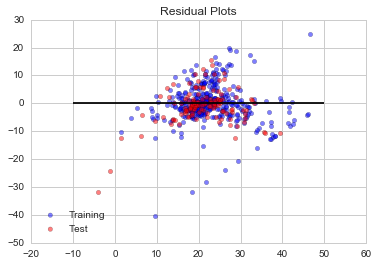

In [32]:
# Scatter plot the training data
train = plt.scatter(pred_train,(pred_train-Y_train),c='b',alpha=0.5)
# c is color, alpha is transparency.

# Scatter plot the testing data
test = plt.scatter(pred_test,(pred_test-Y_test),c='r',alpha=0.5)

# Plot a horizontal axis line at 0
plt.hlines(y=0,xmin=-10,xmax=50)

#Labels
plt.legend((train,test),('Training','Test'),loc='lower left')
plt.title('Residual Plots')

**Great! Looks like there aren't any major patterns to be concerned about**, it may be interesting to check out the line occuring towards the bottom right, but overall the majority of the residuals seem to be randomly allocated above and below the horizontal.

<span style="color:red">** TO check for these line occuring towards the bottom right, try removing a few features and redo LR to see if that goes away**.</span>

More information as:  http://scikit-learn.org/stable/modules/linear_model.html#linear-model

# Step 8: Use Decision Tree (lone tree) and Random Forest to predict and compare that to LR

In [33]:
#Note how we previously name the columns as following:
#df = pd.read_csv('./housing.data', header=None, sep=r"\s*", engine='python')
#df.columns = [
#        'crim', # numerical
#        'zn', # numerical
#        'nonretail', # numerical
#        'river', # binary
#        'nox', # numerical
#        'rooms', # numerical
#        'age', # numerical
#        'dis', # numerical
#        'rad', # numerical
#        'tax', # numerical
#        'ptratio', # numerical
#        'b', # numerical
#        'lstat', # numerical
#        'medv', # numerical -- this is the target
#]

#BUT NOW, WE SHOULD SEPARATE THE FEATURE COLUMN "river' from the rest since
#it is categorical (0/1), which we don't need any transformation on.
#FOR THE REMANING 12 COLS OF FEATURES, WE WOULD WANT TO NORMALIZE THOSE SO THAT
#EACH COL HAS MEAN=0 AND VAR=1.

NO_TRANSFORM = ['river']

NUMERICAL_COLS = [
  'crim', # numerical
  'zn', # numerical
  'nonretail', # numerical
  'nox', # numerical
  'rooms', # numerical
  'age', # numerical
  'dis', # numerical
  'rad', # numerical
  'tax', # numerical
  'ptratio', # numerical
  'b', # numerical
  'lstat', # numerical
]
#from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import cross_val_score

### Next, we create a 'DataTransformer' class to transform data from dataframe to numerical matrix
 (Note the Pythonic convention to name a class, without underscore) 

In [34]:
df.head()

,crim,zn,nonretail,river,nox,rooms,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [35]:
df.dis.head()

0    4.0900
1    4.9671
2    4.9671
3    6.0622
4    6.0622
Name: dis, dtype: float64

In [36]:
df.dis.as_matrix()

array([  4.09  ,   4.9671,   4.9671,   6.0622,   6.0622,   6.0622,
         5.5605,   5.9505,   6.0821,   6.5921,   6.3467,   6.2267,
         5.4509,   4.7075,   4.4619,   4.4986,   4.4986,   4.2579,
         3.7965,   3.7965,   3.7979,   4.0123,   3.9769,   4.0952,
         4.3996,   4.4546,   4.682 ,   4.4534,   4.4547,   4.239 ,
         4.233 ,   4.175 ,   3.99  ,   3.7872,   3.7598,   3.3603,
         3.3779,   3.9342,   3.8473,   5.4011,   5.4011,   5.7209,
         5.7209,   5.7209,   5.7209,   5.1004,   5.1004,   5.6894,
         5.87  ,   6.0877,   6.8147,   6.8147,   6.8147,   6.8147,
         7.3197,   8.6966,   9.1876,   8.3248,   7.8148,   6.932 ,
         7.2254,   6.8185,   7.2255,   7.9809,   9.2229,   6.6115,
         6.6115,   6.498 ,   6.498 ,   6.498 ,   5.2873,   5.2873,
         5.2873,   5.2873,   4.2515,   4.5026,   4.0522,   4.0905,
         5.0141,   4.5026,   5.4007,   5.4007,   5.4007,   5.4007,
         4.7794,   4.4377,   4.4272,   3.7476,   3.4217,   3.4

C:\Users\Tho7\Anaconda3\lib\site-packages\pandas\io\parsers.py:1728: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\Tho7\Anaconda3\lib\site-packages\pandas\io\parsers.py:1730: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\Tho7\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


ymin: 2.0 ymax: 4.0


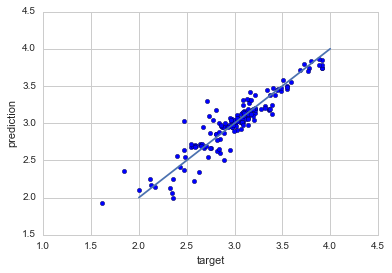

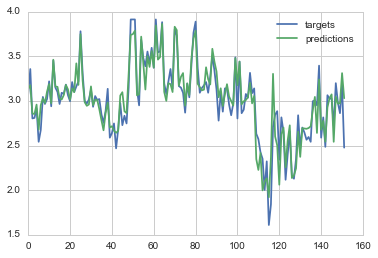

CV single tree: 0.695790640666
CV baseline: 0.722538371642
CV forest: 0.840778264395
test score single tree: 0.705920547462
test score baseline: 0.798906321049
test score forest: 0.864708017101


In [37]:
#BELOW, WE CREATE A CLASS CALLED DataTransformer TO FIT (NORMALIZED) AND
#TRANSFORM (CONVERT FROM DF TO NUMPY MATRIX) THE DATA.

#NOTE THAT WE DIVIDE FIT AND TRANSFORM INTO 2 SEPARATE FUNCTIONS, SINCE
#FOR TRAINING DATA WE WANT TO DO BOTH OPERATIONS ON THEM, AS FITTING IS
#NECESSARY TO PREVENT ONE FEATURE DOMINATING THE OTHER FEATURE.

#WHILE FOR TESTING DATA WE ONLY WANT TO TRANSFORM THEM AND KEEP THE ORIGINAL SCALE
#i.e. FOR BETTER INTERPRETATION.

#this DataTransformer class works like the scikit learn scalar class, which
#has the funcs fit, transform, and fit_transform.
class DataTransformer:
    #the first function, .fit() is to go through each numerical col of the df
    #and find mean and variance of those. Then, save it to a dictionary where
    #each key=col name, each value is a StandardScaler object which store info
    #about the mean and std of that col.
    def fit(self, df):
        self.scalers = {} #an empty dict to store all means and std of each col of df.
        for col in NUMERICAL_COLS:
            scaler = StandardScaler()#define it as an object
            scaler.fit(df[col].as_matrix().reshape(-1, 1))#.fit() is to compute mean, std
            #b4 that, we have converted a df col to a numpy multi-array (i.e. matrix)
            #by using .as_matrix(). Moreover, we reshape it to have 1 column only.
            #so as to keep the format of a col of the df.
            #note that -1 means don't care the first shape (i.e. num of rows), while 1 
            #means we want only one col, thus num of rows should be number of data points
            #Now, scaler is a StandardScaler object will the info from this col, e.g.,
            #you can see these info by calling: scaler.mean_, scaler.scale_, scaler.var_, ect.
            
            self.scalers[col] = scaler
  
    #the second function, .transform(), is to transform w/o fitting, 
    #because when we find the mean and var of a feature, we only want to use
    #the train set. This mean and var info is then used for testing too.
    #this transform func is to subtract the mean and divide by the var.
    def transform(self, df):
        N, D = df.shape
        X = np.zeros((N, D)) #empty N by D matrix
        i = 0
        #for col, scaler in self.scalers.iteritems():#for Python 2
        for col, scaler in self.scalers.items():#for Python 3
            X[:,i] = scaler.transform(df[col].as_matrix().reshape(-1, 1)).flatten()
            #the func .transform() simply convert the whole numpy array inside
            #to another array by subtracting the mean and then divided by the std.
            #flatten to stretch it out to a simple numpy array instead of an array of array
            #Thus, now the col X[:,i] is a standardized array already.
            i += 1
            
        for col in NO_TRANSFORM:#no need to transform the categorical 0/1 column.
            X[:,i] = df[col]
            i += 1
        return X # we actually return this data matrix from the data frame
    
    #to do both of fit and transform function, make it a clear process
    #we return a numpy matrix of all the standardized data.
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)


#NOW, WE ACTUALLY LOAD THE DATA FROM THE FILE, AND THEN
#TRANSFORM IT USING THE ABOVE DataTransformer CLASS.
  
#the data is sort of like a csv, except the cols are separated by
#an arbitrary number of spaces. Luckily we can use this regex sep=r"\s*"
#to indicate an arbitrary number of spaces. We also need to indicate 
#the engine we are using is Python, so that we can use regex.
#The datafile also has no col headers, so we'll need to rename the cols
#manually. Note that now the columns include all 12 numerical columns and
#the one categorical column.
def get_data():#for loading and transforming data.    
    # regex allows arbitrary number of spaces in separator
    df = pd.read_csv('./housing.data', header=None, sep=r"\s*", engine='python')
    df.columns = [
        'crim', # numerical
        'zn', # numerical
        'nonretail', # numerical
        'river', # binary
        'nox', # numerical
        'rooms', # numerical
        'age', # numerical
        'dis', # numerical
        'rad', # numerical
        'tax', # numerical
        'ptratio', # numerical
        'b', # numerical
        'lstat', # numerical
        'medv', # numerical -- this is the target
    ]

    #create an instance of the DataTransformer and use it to transform the data
    transformer = DataTransformer()

    #NOW, WE RANDOMLY SELECT THE TRAINING AND TEST SET.
    N = len(df) #simply the number of rows of a dataframe. 
    #note that len(df.index) may be a bit faster than len(df)
    #while both of these are not equivalent to len(df.count()), which count the 
    #number of rows excluding NaN values, which make it even slower.
    
    #split the data into 70% train and 30% test
    train_idx = np.random.choice(N, size=int(0.7*N), replace=False)
    test_idx = [i for i in range(N) if i not in train_idx]
    df_train = df.loc[train_idx] #TRAINING DF
    df_test = df.loc[test_idx] #TESTING DF

    #now fit and transform the training data,
    #while only need to transform (w/o fitting) the testing data.
    Xtrain = transformer.fit_transform(df_train) #convert from df to numpy matrix
    Ytrain = np.log(df_train['medv'].as_matrix())
    Xtest = transformer.transform(df_test)
    Ytest = np.log(df_test['medv'].as_matrix())
    return Xtrain, Ytrain, Xtest, Ytest
    #note that the take the log of the target, which is the median house prices.
    #this is a common operation for scaling numerical cols that have large ranges
    #but you only care about how correct you are relative to the values.
    #what we mean by that is: if you have a house of $10,000, and you are $5,000 off
    #on your prediction, then you'll consider that "very wrong" prediction.
    #But if you have a $1,000,000 house, and you are $5,000 off, you don't care much.

#FINALLY, WE ARRIVE AT THE MAIN FUNCTION
if __name__ == '__main__':
    Xtrain, Ytrain, Xtest, Ytest = get_data()

    #first, create an instance of a RF.
    #now we use 100 trees, but encourage to try different values, maybe up to 500
    model = RandomForestRegressor(n_estimators=100) # try 10, 20, 50, 100, 200
    model.fit(Xtrain, Ytrain) #find coeff of the model
    predictions = model.predict(Xtest) #get the prediction, so that
    #later we can compare with the target.

    # plot predictions vs targets
    plt.scatter(Ytest, predictions)#target is x-axis, predictions is y-axis
    #if the prediction is accurate, then this curve is close to the line y=x
    #so here we are plotting y=x for comparison too.
    plt.xlabel("target")
    plt.ylabel("prediction")
    ymin = np.round( min( min(Ytest), min(predictions) ) )
    ymax = np.ceil( max( max(Ytest), max(predictions) ) )
    print("ymin:", ymin, "ymax:", ymax)
    r = range(int(ymin), int(ymax) + 1)
    plt.plot(r, r)
    plt.show()


    #do an alternative plots, with just target and prediction separately
    plt.plot(Ytest, label='targets')
    plt.plot(predictions, label='predictions')
    plt.legend()
    plt.show()

    #do Cross-Validation on all of our models (by default, it's a 3-fold CV)
    # do a quick baseline test
    baseline = LinearRegression() #baseline
    single_tree = DecisionTreeRegressor() #single DT
    print("CV single tree:", cross_val_score(single_tree, Xtrain, Ytrain).mean())
    print("CV baseline:", cross_val_score(baseline, Xtrain, Ytrain).mean())
    print("CV forest:", cross_val_score(model, Xtrain, Ytrain).mean())


    #we also print the test error of all 3 models
    # test score
    single_tree.fit(Xtrain, Ytrain)
    baseline.fit(Xtrain, Ytrain)
    print("test score single tree:", single_tree.score(Xtest, Ytest))
    print("test score baseline:", baseline.score(Xtest, Ytest))
    print("test score forest:", model.score(Xtest, Ytest))

#for the train score:
#Single DT does bad, only 0.61, the baseline a bit better: 0.69,
#the RF is even better: 0.80

#the same pattern reflects in the test score too.